# Plotting VIMS and UVIS occultation ED data vs. time, Prometheus distance

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         compute_corrected_ew_col,
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)
import datetime as dt
pd.set_option('display.max_rows', None)

In [29]:
# Define functions to process EW data

def remove_eqx(orig_obsdata, eqx_cutoff):
    #remove EQX observations
    #orig_obsdata: original pandas dataframe
    #returns: obsdata (EQX observations removed)
    
    good_i = np.abs(orig_obsdata['Incidence']-90) > eqx_cutoff
    obsdata = orig_obsdata[good_i]
    print('Removed EQX OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
    print('Unique observation names:', len(obsdata))
    print()
    
    return obsdata

def remove_outliers(obsdata, outlier_obs):
    #remove 3 outliers from ~phase 50-60 before fitting for tau
    #(located by hand, removing from all 3 by observation name)
    
    for obsid in outlier_obs:
        #drop row containing outlier ob
        obsdata = obsdata[obsdata.index != obsid]
            
    print('Removed outlier OBSIDs:', outlier_obs)
    print('Unique observation names:', len(obsdata))
    print()
    return obsdata

In [30]:
def trendline(obsdata, x_col, y_col, deg, time_data=False):
    #returns x, y data for trendline for the data vs. time 
    
    
    if time_data:
        #convert dates to floats to be able to use for polyfit (days since first observation)
        obsdata['Time Delta'] = (obsdata[x_col] - obsdata[x_col].min()) \
                                            / np.timedelta64(1,'D')
        x_vals_to_fit = obsdata['Time Delta']
    else:
        x_vals_to_fit = obsdata[x_col]
    
    #calculate + plot the best-fit line (no outliers)
    #calculate best-fit line for EW vs. time data to plot on top
    coeff = np.polyfit(x_vals_to_fit, obsdata[y_col], deg=deg)
    x_min = x_vals_to_fit.min()
    x_max = x_vals_to_fit.max()
    xrange = np.linspace(x_min, x_max, 100)
    
    if time_data:
        xrange_vals = [obsdata[x_col][0]+ dt.timedelta(days = x_days) for x_days in xrange]
    else:
        xrange_vals = xrange
    
    return xrange_vals, np.polyval(coeff, xrange)


def ed_vs_time(data, ed_cols=['Core30 ED', 'Core50 ED', 'Full ED'], deg=3):
    
    #convert dates to floats to be able to use for polyfit (days since first observation)
    data['Ring Event Mean Time Delta'] = (data['Ring Event Mean Time'] - data['Ring Event Mean Time'].min()) \
                                            / np.timedelta64(1,'D')
    
    plt.figure(figsize=(5*len(ed_cols),3))
    for i in range(len(ed_cols)):
        plt.subplot(1, len(ed_cols), i+1)
        plt.scatter(data['Ring Event Mean Time'], data[ed_cols[i]], c='seagreen')
        
        #calculate best-fit line to plot on top of data (ED vs. Time)
        coeff = np.polyfit(data['Ring Event Mean Time Delta'], data[ed_cols[i]], deg=deg)
        x_min = data['Ring Event Mean Time Delta'].min()
        x_max = data['Ring Event Mean Time Delta'].max()
        xrange = np.linspace(x_min, x_max, 100)
        xrange_dates = [data['Ring Event Mean Time'][0]+ dt.timedelta(days = x_days) for x_days in xrange]
        plt.plot(xrange_dates, np.polyval(coeff, xrange), '-', color='black')
        
        plt.xlabel('Ring Event Mean Time')
        plt.ylabel('Equivalent Depth')
        plt.title('Equivalent Depth vs. Time ('+ed_cols[i]+')')
    plt.show()
    


def ed_vs_p_dist(data, ed_cols=['Core30 ED', 'Core50 ED', 'Full ED'], deg=1):
    
    plt.figure(figsize=(5*len(ed_cols),3))
    for i in range(len(ed_cols)):
        plt.subplot(1, len(ed_cols), i+1)
        plt.scatter(data['Prometheus Distance'], data[ed_cols[i]], c='darkmagenta')
        
        #calculate best-fit line to plot on top of data (ED vs. Prom. Dist)
        coeff = np.polyfit(data['Prometheus Distance'], data[ed_cols[i]], deg=1)
        x_min = data['Prometheus Distance'].min()
        x_max = data['Prometheus Distance'].max()
        xrange = np.linspace(x_min, x_max, 100)
        plt.plot(xrange, np.polyval(coeff, xrange), '-', color='black')
        
        plt.xlabel('Prometheus Distance (km)')
        plt.ylabel('Equivalent Depth')
        plt.title('Equivalent Depth vs. Prometheus Distance \n('+ed_cols[i]+')')
    plt.show()
    

    
def ew_ed_vs_time(ed_data, ew_data, ed_col='Full ED', ew_col='Normal EW3ZPN'):

    fig, ax1 = plt.subplots() 

    ax1.set_xlabel('Time') 
    ax1.set_ylabel('Equivalent Depth', color = 'tab:blue') 
    ax1.scatter(ed_data['Ring Event Mean Time'], ed_data[ed_col], color = 'tab:blue', alpha=0.7) 
    ax1.tick_params(axis ='y', labelcolor = 'tab:blue') 

    # Adding Twin Axes
    ax2 = ax1.twinx() 

    ax2.set_ylabel('Equivalent Width', color = 'tab:red') 
    ax2.scatter(ew_data['Date'], ew_data[ew_col], color = 'tab:red', alpha=0.7) 
    ax2.tick_params(axis ='y', labelcolor = 'tab:red') 

    # Show plot
    plt.show()
    

In [31]:
# Define variables
# Columns are occultation name, equivalent tau for the +/-50 km core, ED for 30km, 50km, and 500km.

# path to data directory
data_directory = '/Users/mlessard/REU_2022/data/'

# VIMS filepath
vims_filepath = data_directory+'vims_occultations.csv'

# UVIS filepath
uvis_filepath = data_directory+'uvis_occultations.csv'

# path to Prometheus distance file
dist_filepath = data_directory+'prometheus_dist.csv'

In [32]:
# load in ED data

vims_data = pd.read_csv(vims_filepath, parse_dates=['Ring Event Mean Time'], index_col='Occultation Name')
uvis_data = pd.read_csv(uvis_filepath, parse_dates=['Ring Event Mean Time'], index_col='Occultation Name')

print(vims_data.columns)

Index(['Ring Event Start Time', 'Ring Event End Time', 'Ring Event Mean Time',
       'RevNo', 'Observation Name', 'Star Name', 'Direction',
       'Minimum Wavelength', 'Maximum Wavelength', 'Data Quality Score',
       'Minimum Inertial Longitude', 'Maximum Inertial Longitude',
       'Mean Inertial Longitude', 'Minimum Co-Rot Longitude',
       'Maximum Co-Rot Longitude', 'Mean Co-Rot Longitude', 'Ring Elevation',
       'Lowest Detectable Opacity', 'Highest Detectable Opacity',
       'Prometheus Distance', 'Equivalent Tau', 'Core30 ED', 'Core50 ED',
       'Full ED', 'Before ISS ObsName', 'Before ISS Delta',
       'After ISS ObsName', 'After ISS Delta'],
      dtype='object')


In [33]:
# load in normal EW data (use default PN, corrected column)

# directory of dumped EW csv files
dump_ew_dir = '/Users/mlessard/REU_2022/data/dump_ew_csv/'

#using the CSV data created with 3 regions or not?
three_region = True

#radii values (three-region)
radii = [139470, 140170, 140265, 140965]

# slice/step size of the csv file, currently only have 0
size = 0

# degrees within 90 (incidence angle) to cut off/get rid of observations
eqx_cutoff = 1.5

#remove outliers? (not including EQX values)
rm_outliers = True

# list outlier obsids (phase curve)
outliers = ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME']
#outliers_inner = ['ISS_177RF_FRSTRCHAN001_PRIME_2', 'ISS_201RF_FMOVIE001_PRIME_2', 'ISS_079RF_FRINGMRLF002_PRIME', 'ISS_235RF_FMOVIE001_PRIME']
#outliers_outer = []#'ISS_051RI_LPMRDFMOV001_PRIME'] #outlier ~57 phase angle in width vs. phase angle plots
outliers = outliers + ['ISS_041RF_FMOVIE002_VIMS', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_039RF_FMOVIE001_VIMS'] #105 outliers
outliers = outliers + ['ISS_041RF_FMOVIE001_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS'] #85 outliers

#get the full-width image data
full_img_filepath = f'{dump_ew_dir}ew_stats_widths_{radii[0]}_{radii[1]}_{radii[2]}_{radii[3]}_{size}.csv'
full_orig_obsdata = pd.read_csv(full_img_filepath, parse_dates=['Date'], index_col='Observation')

#remove EQX observations
removed_eqx_obsdata = remove_eqx(full_orig_obsdata, eqx_cutoff)

#remove outliers
if rm_outliers:
    obsdata = remove_outliers(removed_eqx_obsdata, outliers)
else:
    obsdata = removed_eqx_obsdata

Removed EQX OBSIDs: {'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2'}
Unique observation names: 145

Removed outlier OBSIDs: ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME', 'ISS_041RF_FMOVIE002_VIMS', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_039RF_FMOVIE001_VIMS', 'ISS_041RF_FMOVIE001_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS']
Unique observation names: 136



# VIMS data

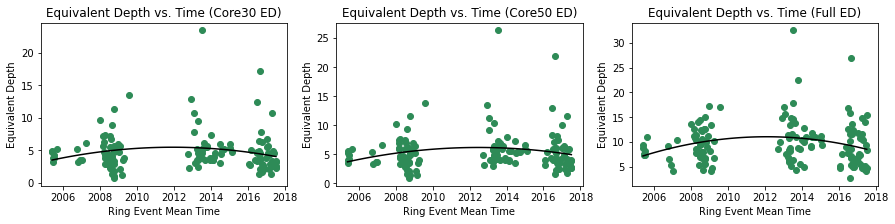

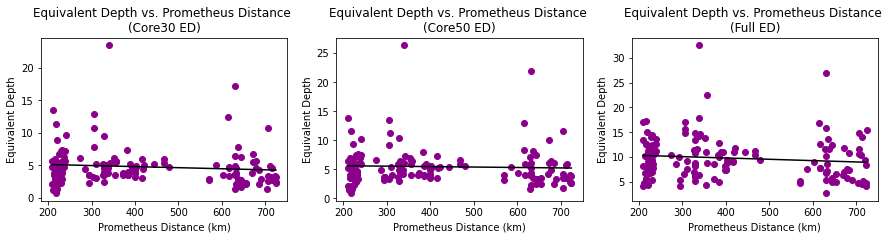

In [34]:
# Plot VIMS ED vs. time, vs. Prometheus distance
ed_vs_time(vims_data, deg=2)
ed_vs_p_dist(vims_data)

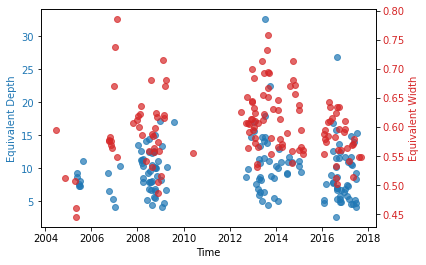

In [35]:
# Plot Normal EW, ED vs. time for the VIMS observations
ew_ed_vs_time(vims_data, obsdata)

# UVIS data

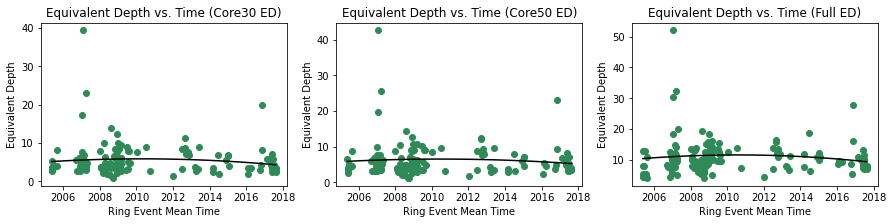

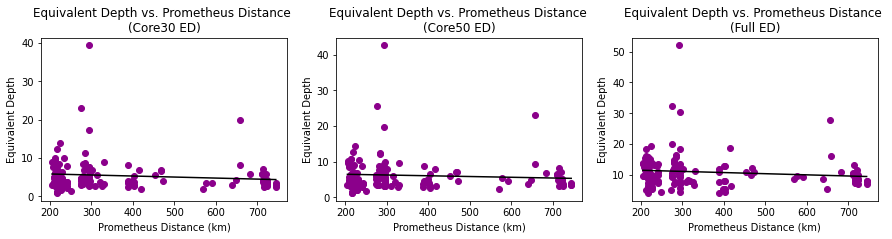

In [36]:
# Plot UVIS ED vs. time, vs. Prometheus distance
ed_vs_time(uvis_data, deg=2)
ed_vs_p_dist(uvis_data)

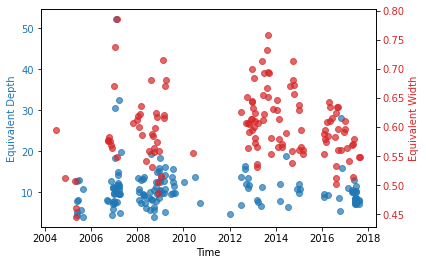

In [37]:
# Plot Normal EW, ED vs. time for the UVIS observations
ew_ed_vs_time(uvis_data, obsdata)

# Combining VIMS and UVIS datasets

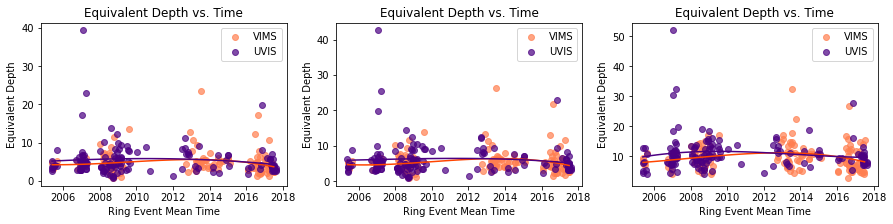

In [38]:
# (color-code by instrument just so we can see if there's any dependency)
# plot VIMS and UVIS ED vs. time
#convert dates to floats to be able to use for polyfit (days since first observation)
ed_cols=['Core30 ED', 'Core50 ED', 'Full ED']

vims_c = 'coral'
uvis_c = 'indigo'

plt.figure(figsize=(5*len(ed_cols),3))
for i in range(len(ed_cols)):
    plt.subplot(1, len(ed_cols), i+1)
    plt.scatter(vims_data['Ring Event Mean Time'], vims_data[ed_cols[i]], c=vims_c, alpha=0.7, label='VIMS')
    plt.scatter(uvis_data['Ring Event Mean Time'], uvis_data[ed_cols[i]], c=uvis_c, alpha=0.7, label='UVIS')
    
    (x_trend_vims, y_trend_vims) = trendline(vims_data, x_col='Ring Event Mean Time', \
                                             y_col=ed_cols[i], deg=3, time_data=True)
    (x_trend_uvis, y_trend_uvis) = trendline(uvis_data, x_col='Ring Event Mean Time', \
                                             y_col=ed_cols[i], deg=3, time_data=True)
    
    plt.plot(x_trend_vims, y_trend_vims, '-', color='orangered')
    plt.plot(x_trend_uvis, y_trend_uvis, '-', color='indigo')
    
    plt.xlabel('Ring Event Mean Time')
    plt.ylabel('Equivalent Depth')
    plt.title('Equivalent Depth vs. Time') # ('+ed_cols[i]+')')
    plt.legend()
plt.show()



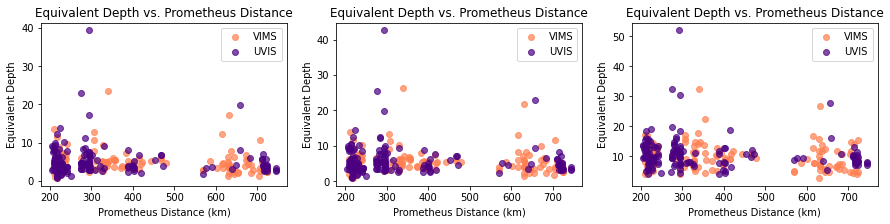

In [39]:
# plot VIMS and UVIS ED vs. Prometheus Distance
plt.figure(figsize=(5*len(ed_cols),3))
for i in range(len(ed_cols)):
    plt.subplot(1, len(ed_cols), i+1)
    plt.scatter(vims_data['Prometheus Distance'], vims_data[ed_cols[i]], c=vims_c, alpha=0.7, label='VIMS')
    plt.scatter(uvis_data['Prometheus Distance'], uvis_data[ed_cols[i]], c=uvis_c, alpha=0.7, label='UVIS')
    
    plt.xlabel('Prometheus Distance (km)')
    plt.ylabel('Equivalent Depth')
    plt.title('Equivalent Depth vs. Prometheus Distance') # \n('+ed_cols[i]+')')
    plt.legend()
plt.show()

Removed outlier OBSIDs: ['VIMS_2007_001_RHYA_I', 'VIMS_2013_189_2CEN_I', 'VIMS_2013_281_L2PUP_I', 'VIMS_2014_022_L2PUP_I', 'VIMS_2014_022_L2PUP_E', 'VIMS_2016_234_ALPORI_E', 'VIMS_2017_001_GAMCRU_I', 'VIMS_2017_094_LAMVEL_I']
Unique observation names: 142

Removed outlier OBSIDs: ['UVIS_HSP_2007_015_DELPER_I', 'UVIS_HSP_2007_022_GAMARA_I', 'UVIS_HSP_2007_080_GAMGRU_I', 'UVIS_HSP_2016_315_ALPLUP_E']
Unique observation names: 142



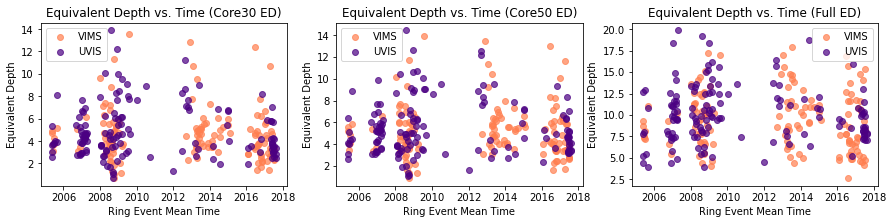

In [40]:
# Figuring out how to get rid of the VIMS/UVIS observations creating the spikes

vims_outliers = []
vims_outliers = vims_outliers + ['VIMS_2007_001_RHYA_I'] #2006 event
vims_outliers = vims_outliers + ['VIMS_2013_189_2CEN_I', \
                                 'VIMS_2013_281_L2PUP_I', 'VIMS_2014_022_L2PUP_I', 'VIMS_2014_022_L2PUP_E'] #2013/14 event
vims_outliers = vims_outliers + ['VIMS_2016_234_ALPORI_E', \
                                 'VIMS_2017_001_GAMCRU_I', 'VIMS_2017_094_LAMVEL_I'] #2016/17 event
                                
uvis_outliers = []
uvis_outliers = uvis_outliers + ['UVIS_HSP_2007_015_DELPER_I', 'UVIS_HSP_2007_022_GAMARA_I', \
                                 'UVIS_HSP_2007_080_GAMGRU_I']  #2006 event
uvis_outliers = uvis_outliers + [] #no obs for ~2013/14 event for UVIS
uvis_outliers = uvis_outliers + ['UVIS_HSP_2016_315_ALPLUP_E'] #2017 event

rm_outliers = True

if rm_outliers:
    vims_data = remove_outliers(vims_data, vims_outliers)
    uvis_data = remove_outliers(uvis_data, uvis_outliers)
    

# (color-code by instrument just so we can see if there's any dependency)
# plot VIMS and UVIS ED vs. time
#convert dates to floats to be able to use for polyfit (days since first observation)
ed_cols=['Core30 ED', 'Core50 ED', 'Full ED']

vims_c = 'coral'
uvis_c = 'indigo'

plt.figure(figsize=(5*len(ed_cols),3))
for i in range(len(ed_cols)):
    plt.subplot(1, len(ed_cols), i+1)
    plt.scatter(vims_data['Ring Event Mean Time'], vims_data[ed_cols[i]], c=vims_c, alpha=0.7, label='VIMS')
    plt.scatter(uvis_data['Ring Event Mean Time'], uvis_data[ed_cols[i]], c=uvis_c, alpha=0.7, label='UVIS')
    
    plt.xlabel('Ring Event Mean Time')
    plt.ylabel('Equivalent Depth')
    plt.title('Equivalent Depth vs. Time ('+ed_cols[i]+')')
    plt.legend()
plt.show()